In [1]:
#RUN ONLY ONCE
import cv2
import numpy as np
from matplotlib import pyplot as plt
import time
import math

In [2]:
#RUN ONLY ONCE
cap = cv2.VideoCapture(0)
    
if not cap.isOpened():
    print("Could not access webcam")

In [3]:
def get_picture_optimized(cap):
    """
    Capture a frame from the webcam, return it as a BGR numpy array.
    """
    
    w = 1920
    h = 1080

    cap.set(cv2.CAP_PROP_FRAME_WIDTH, w)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, h)
    time.sleep(0.1)  # let the camera apply settings
    
    ret, frame = cap.read()
    #cap.release()
    
    if ret:
        return frame
    else:
        print("Failed to capture frame")
        return None

In [9]:
#================HYPERPARAMETESRS======================

#REAL SiZE OF THE ENVIRONEMENT (cm)
L = 113.5
W = 81.3
Ratio = L/W

#SiZE IN PIXEL OF THE CORRECTED MAP
Y_res = 480
SIZE = [Y_res, int(Y_res*Ratio)]


#FILTERING PARAMETERS FOR THE ORIGINAL IMAGE
B1_O = 10
B2_O = 80
B3_O = 80
C1_O = 0.5
C2_O = 1.5
M1_O = 8
CL1_O = 2.0

#FILTERING PARAMETERS FOR THE CORRECTED IMAGE
B1_C = 5
B2_C = 10
B3_C = 10
C1_C = 0.4
C2_C = 1.6
M1_C = 5
CL1_C = 4.0

#FILTERING PARAMETERS FOR ROBOT DETECTION
B1_T = 5
B2_T = 10
B3_T = 10
C1_T = 0.4
C2_T = 1.6
M1_T = 5
CL1_C = 4.0


#PARAMETERS TO DETECT THE ENV
Min_area_env = 1000   #Min area in pixel of the env
Env_approx = 0.02

#PARAMETERS TO DETECT THE OBSTACLES
Min_area_obs = 500   #Min area in pixel of the env
Square_approx = 0.05

#PARAMETERS TO DETECT GOAL
Min_area_goal = 50
Max_area_goal = 10000

#PARAMETERS TO DETECT THE ROBOT
Min_area_rob = 100   #Min area in pixel of the env
Rob_approx = 0.05

#ROBOT CARACTERISTICS
R_ROBOT = 20


#SYMBOLS FOR THE MAP
FREE_SPACE = -1
OCCUPIED_SPACE = -2
GOAL = -3

DEBUG = True
#========================================================

In [14]:
#=====GEOMETRICAL FUNCIONS=====
def orderpoints(pts) :
    """
    INPUT : 4 points
    OUTPUT : 4 points ordered
    Order points of a square counterclockwise
    """
    pts = pts[np.argsort(pts[:, 1]), :]  # sort by y
    
    # Step 2: top two points
    top = pts[:2]
    # bottom two points
    bottom = pts[2:]
    
    # Step 3: sort top-left and top-right by x
    if top[0, 0] < top[1, 0]:
        tl, tr = top[0], top[1]
    else:
        tl, tr = top[1], top[0]
        
    # Step 4: sort bottom-left and bottom-right by x
    if bottom[0, 0] < bottom[1, 0]:
        bl, br = bottom[0], bottom[1]
    else:
        bl, br = bottom[1], bottom[0]
    
    return np.array([tl, tr, br, bl], dtype="float32")


def find_square(contour, approx, area) :
    """
    INPUT : IMAGE, percentage of approximation, minimum area
    OUTPUT : if a square is detected, square countour
    """
    
    cnt_len = cv2.arcLength(contour, True)
    cnt = cv2.approxPolyDP(contour, approx*cnt_len, True) 
    if len(cnt) == 4 and cv2.contourArea(cnt) > area and cv2.isContourConvex(cnt):
        find = True
        return find, cnt.reshape(-1,2)
    else : 
        find = False
        return find, None
    
def find_triangle(contour, approx = 0.08, area = 100000, image = None) :
    cnt_len = cv2.arcLength(contour, True)
    cnt = cv2.approxPolyDP(contour, approx*cnt_len, True)

    if DEBUG :
        image_plot = image.copy()
        cv2.drawContours(image_plot, [cnt], -1, (255, 0, 0), 2)

    if DEBUG :
        plt.figure()
        plt.imshow(cv2.cvtColor(image_plot, cv2.COLOR_BGR2RGB))
        plt.title("Potential triangle")
        plt.axis('off')
        plt.show()
    
        
    elem = []
    if len(cnt) == 3 and cv2.contourArea(cnt) > area :
        cnt = cnt.reshape(-1, 2)
        elem = cnt
        find = True
        return find, elem
    else : 
        find = False
        return find, elem
        return find, elem

def find_circle(contour, min_area, max_area) :
    (x, y), radius = cv2.minEnclosingCircle(contour)

    area_contour = cv2.contourArea(contour)
    area_circle = np.pi * radius * radius
    find = False
    circularity = area_contour / area_circle
    circle = []
    
    if 0.5 < circularity < 1.9 and (area_circle > min_area and area_circle < max_area):
        
        center = (int(x), int(y))
        radius = int(radius)
        circle = [center,radius]
        find = True
        return find, circle, circularity
    
    return find, circle, circularity

        
def get_inter_shape(squares):
    occupancy = np.zeros((SIZE[0], SIZE[1]))
    for shape in squares:
        pts = orderpoints(shape).astype(np.int32)
        cv2.fillConvexPoly(occupancy, pts, 1)
    return occupancy

def altitude_line(A, B, C):
    Ax, Ay = A
    Bx, By = B
    Cx, Cy = C

    # base vector B-C
    ux = Cx - Bx
    uy = Cy - By

    # perpendicular vector
    vx = -uy
    vy =  ux

    # équation paramétrique : (x,y) = A + t * v
    return (Ax, Ay), (vx, vy)
    
def order_triangle(P1,P2,P3) :
    dist_A = math.dist(P1, P2)
    dist_B = math.dist(P2, P3)
    dist_C = math.dist(P3, P1)
    
    diff_A_B = abs(dist_A-dist_B)
    diff_B_C = abs(dist_B-dist_C)
    diff_C_A = abs(dist_C-dist_A)
    
    if diff_A_B < diff_B_C and diff_A_B < diff_C_A :
        TOP = P2
        LEFT = P1
        RIGHT = P3
        confidence = diff_A_B
    elif diff_B_C < diff_A_B and diff_B_C < diff_C_A :
        TOP = P3
        LEFT = P2
        RIGHT = P1
        confidence = diff_B_C
    elif diff_C_A < diff_A_B and diff_C_A < diff_B_C :
        TOP = P1
        LEFT = P3
        RIGHT = P2
        confidence = diff_C_A
    else :
        print("no summit found, adjust threshold")

    ordered = [TOP,LEFT, RIGHT]
    return ordered, confidence
    
def get_occupancy(squares):
    occupancy = np.zeros((SIZE[0], SIZE[1]))
    for shape in squares:
        pts = orderpoints(np.array(shape)).astype(np.int32)
        cv2.fillConvexPoly(occupancy, pts, OCCUPIED_SPACE)
    return occupancy

def square_overlaps_circle(square, cx, cy, r):
    # 1. Check if a vertex of the square is inside the circle
    for (x, y) in square:
        if (x - cx)**2 + (y - cy)**2 <= r*r:
            return True

    # 2. Check if circle center is inside the square (rare but possible)
    if cv2.pointPolygonTest(square.astype(np.float32), (cx, cy), False) >= 0:
        return True

    return False

In [15]:
#=====FILTERING FUNCTIONS=====
def filter_image(image, b1, b2, b3, c1, c2, m1, cl1) :
    """
    INPUT : IMAGE AND FILTER PARAMETERS
    OUTPUT : IMAGE FILTERED
    Apply successive filters to a given image : 
    1. Convert to GreyScale
    2. Bilatera filter
    3. Canny edge filter
    4. Morphological filter
    """
    # Grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    """
    #Clahe filter
    clahe = cv2.createCLAHE(clipLimit=cl1, tileGridSize=(8,8))
    cl1 = clahe.apply(gray)
    
    if DEBUG :
        plt.figure()
        plt.imshow(cl1, cmap='gray')
        plt.title("Improve contrast")
        plt.axis('off')
        plt.show()
    """
    # Bilateral filter
    filtered_img = cv2.bilateralFilter(gray, b1, b2, b3)

    if DEBUG :
        plt.figure()
        plt.imshow(filtered_img, cmap='gray')
        plt.title("Bilateral image")
        plt.axis('off')
        plt.show()
    
    # Canny edges
    median_val = np.median(gray)
    lower = int(max(0, c1 * median_val))
    upper = int(min(255, c2 * median_val))
    canny_img = cv2.Canny(filtered_img, lower, upper)

    if DEBUG :
        plt.figure()
        plt.imshow(canny_img, cmap='gray')
        plt.title("canny image")
        plt.axis('off')
        plt.show()
    
    # Morphological filter
    kernel1 = np.ones((5,5), np.uint8)
    kernel2 = np.ones((5,5), np.uint8)
    closed = cv2.morphologyEx(canny_img, cv2.MORPH_CLOSE, kernel1)
    
    closed = cv2.dilate(closed, kernel1, iterations=1)
    closed = cv2.morphologyEx(closed, cv2.MORPH_CLOSE, kernel2)
    #kernel = np.ones((m1,m1), np.uint8)
    #closed = cv2.morphologyEx(canny_img, cv2.MORPH_CLOSE, kernel)

    if DEBUG :
        plt.figure()
        plt.imshow(closed, cmap='gray')
        plt.title("Filtered image")
        plt.axis('off')
        plt.show()
        
    return closed

In [16]:
def matrix_perspective(image) :

    filtered_image = filter_image(image, B1_O, B2_O , B3_O, C1_O, C2_O, M1_O, CL1_O)
    
    contours, hierarchy = cv2.findContours(filtered_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    
    if DEBUG : image_plot = image.copy()
        
    squares = []
    for cnt in contours:
        find = False
        find, square = find_square(cnt, Env_approx, Min_area_env)
        if find :
            squares.append(square)
            if DEBUG :
                cv2.drawContours(image_plot, [square], -1, (255, 0, 0), 2)

    if DEBUG :
        plt.figure()
        plt.imshow(cv2.cvtColor(image_plot, cv2.COLOR_BGR2RGB))
        plt.title("Detected Quadrilaterals (blue)")
        plt.axis('off')
        plt.show()
        print(squares)
    
    area = 0
    sheet = None
    for square in squares:
        if cv2.contourArea(square) > area :
            sheet = square
            area = cv2.contourArea(square)
        
    
    if sheet is not None:
        sheet_ordered = orderpoints(sheet)
        tl, tr, br, bl = [tuple(pt.astype(int)) for pt in sheet_ordered]
    else : print("ERROR : SHEET is EMPTY")
    
    pts1 = sheet_ordered
    pts2 = np.array([[0, 0], [SIZE[1]-1, 0], [SIZE[1]-1, SIZE[0]-1], [0, SIZE[0]-1]],dtype=np.float32)
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    return matrix

def convert_perspective(image,matrix) : 
    
    transformed_image = cv2.warpPerspective(image,matrix,(SIZE[1],SIZE[0]))
    return transformed_image

def pixel_to_world_mm(pos):
    px, py = pos
    x = 10 * px * (L / SIZE[1])
    y = 10 * py * (W / SIZE[0])
    return x, y

def get_robot(image):
    
    filtered_image = filter_image(image, B1_C, B2_C , B3_C, C1_C, C2_C, M1_C, CL1_C)
    
    contours, hierarchy = cv2.findContours(filtered_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    if DEBUG :
        plt.figure()
        image_contours_plot = image.copy()
        cv2.drawContours(image_contours_plot, contours, -1, (0, 255, 0), 2)
        plt.imshow(cv2.cvtColor(image_contours_plot, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title("Contours dessinés")
        plt.show()
     
        image_contours = transformed_image.copy()
    
    triangle =[]
    find_t = False
    confidence = 100
    for cnt in contours:
        find_t, tri= find_triangle(cnt, Rob_approx, Min_area_rob, image)
        #print(tri)
        if find_t :
            _, conf = order_triangle(tri[0], tri[1], tri[2])
            if conf < confidence :
                triangle = tri
                confidence = conf
                if DEBUG :
                    cv2.drawContours(image_contours, [triangle], -1, (255, 0, 0), 2)
                #break
    pos = []
    angle = 0
    if triangle is not None and len(triangle) != 0:
        if DEBUG :
            plt.figure()
            plt.imshow(cv2.cvtColor(image_contours, cv2.COLOR_BGR2RGB))
            plt.title("Detected shapes (blue)")
            plt.axis('off')
            plt.show()
            print(triangle)
            
        tri_ordered,_ = order_triangle(triangle[0], triangle[1], triangle[2])
        alt = altitude_line(tri_ordered[0], tri_ordered[1], tri_ordered[2] )
        pos = alt[0]
        angle = np.atan2(alt[1][1],alt[1][0])
        print("ROBOT FOUND")
        Rob = True
    else :
        print("NO ROBOT FOUND")
        Rob = False
    #pos = pixel_to_world_mm(pos)
    return pos, angle, Rob


def get_map(image) :

    filtered_image = filter_image(image, B1_C, B2_C , B3_C, C1_C, C2_C, M1_C, CL1_C)
   
    
    contours, hierarchy = cv2.findContours(filtered_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    if DEBUG :
        plt.figure()
        image_contours_plot = image.copy()
        cv2.drawContours(image_contours_plot, contours, -1, (0, 255, 0), 2)
        plt.imshow(cv2.cvtColor(image_contours_plot, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title("Contours dessinés")
        plt.show()  
        image_contours = transformed_image.copy()

    
    robot_pos,_, Rob = get_robot(image)
    
    squares =[]
    find_s = False
    find_circ = False
    confidence = 100
    for cnt in contours:
        find_s, square= find_square(cnt, Square_approx, Min_area_obs)
        find_c, circle_pot, confidence_pot = find_circle(cnt, Min_area_goal, Max_area_goal)
        if find_s :
            squares.append(square)
            if DEBUG : cv2.drawContours(image_contours, [square], -1, (255, 0, 0), 2)
        if find_c:
            if Rob : 
                # compute distance between robot and circle
                cx, cy = circle_pot[0]
                rx, ry = robot_pos
                dist = np.hypot(cx - rx, cy - ry)
                # ignore circle if too close to robot
                if abs(confidence_pot - 1) < confidence and dist > R_ROBOT:
                    confidence = abs(confidence_pot - 1)
                    circle = circle_pot
                    find_circ = True
            else :
                if abs(confidence_pot - 1) < confidence :
                    confidence = abs(confidence_pot - 1)
                    circle = circle_pot
                    find_circ = True

    if find_circ:
        cx, cy = circle[0]
        r = circle[1]

        squares = [
            sq for sq in squares
            if not square_overlaps_circle(sq, cx, cy, r)
            ]

   
    if DEBUG :
        plt.figure()
        plt.imshow(cv2.cvtColor(image_contours, cv2.COLOR_BGR2RGB))
        plt.title("Detected shapes (blue)")
        plt.axis('off')
        plt.show()
        #print(squares)
    
    map_ = get_inter_shape(squares)

    
    if find_circ :
        if DEBUG :
            cv2.circle(image_contours, circle[0], circle[1], (0, 255, 0), -1)
            
        (cx, cy) = circle[0]
        radius = circle[1]
        # Dimensions
        h, w = map_.shape
    
        # Grille de coordonnées
        Y, X = np.ogrid[:h, :w]
    
        # Condition du disque (distance <= rayon)
        dist_mask = (X - cx)**2 + (Y - cy)**2 <= radius**2
    
        # Application
        map_[dist_mask] = GOAL
    
        
        map_[cy,cx] = GOAL
        
    if DEBUG :    
        plt.imshow(map_, cmap='gray')
        plt.axis('off')
        plt.show()

    print("MAP ANALYZED : ")
    if find_circ:
       print("GOAL FOUND")
    else:
        print("NO GOAL DETECTED")
       
    return map_

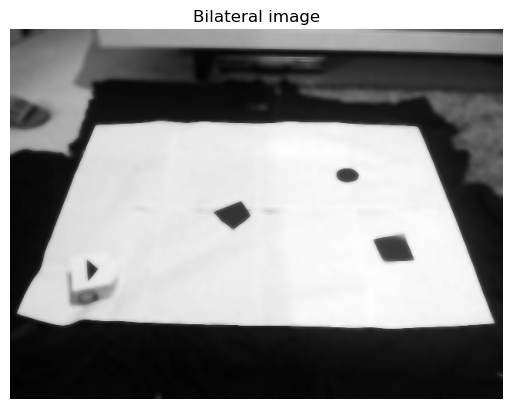

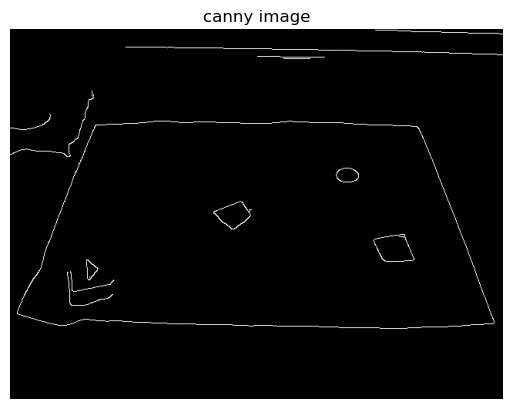

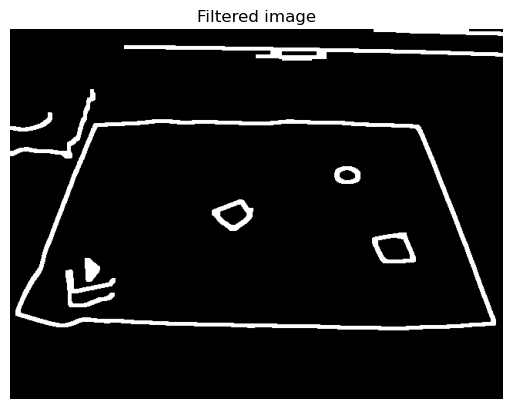

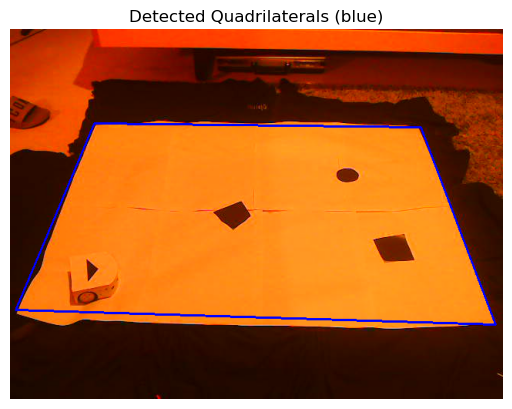

[array([[  7, 364],
       [630, 383],
       [533, 127],
       [109, 122]], dtype=int32)]


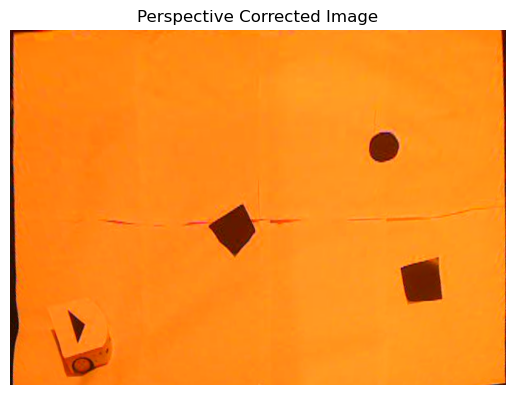

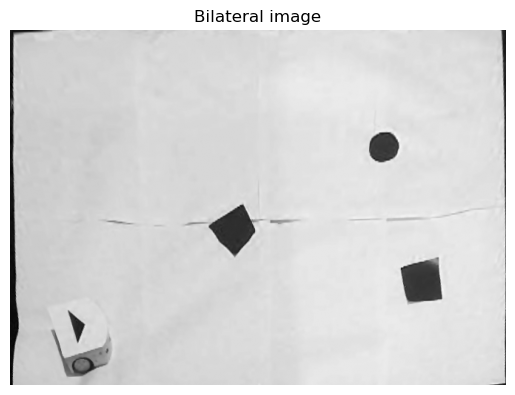

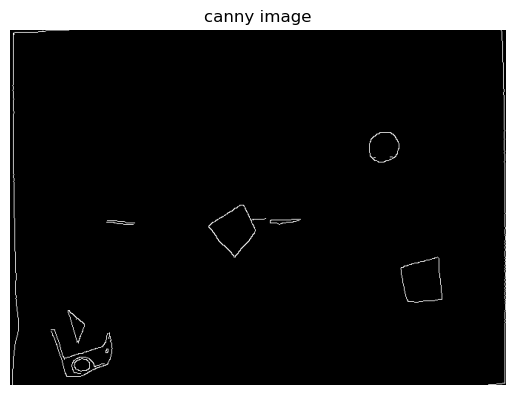

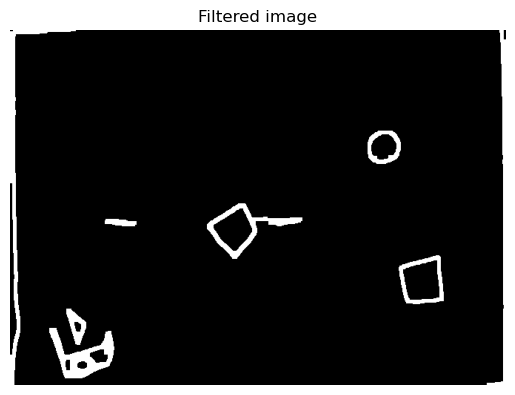

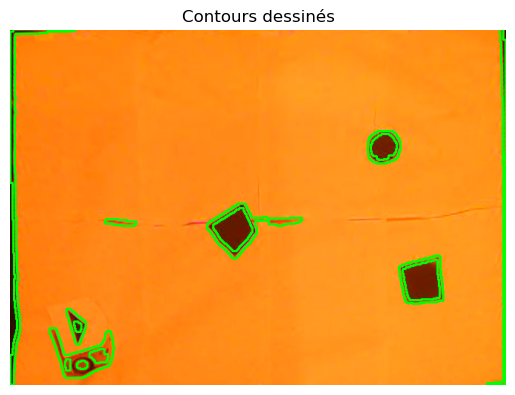

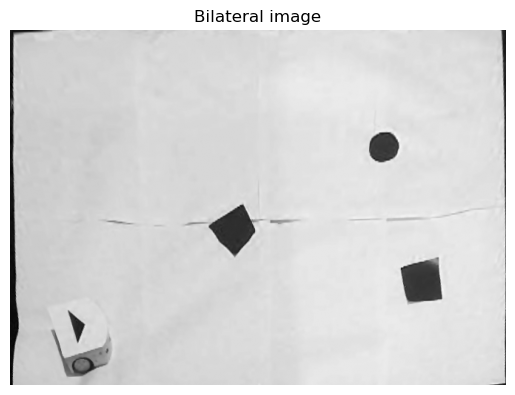

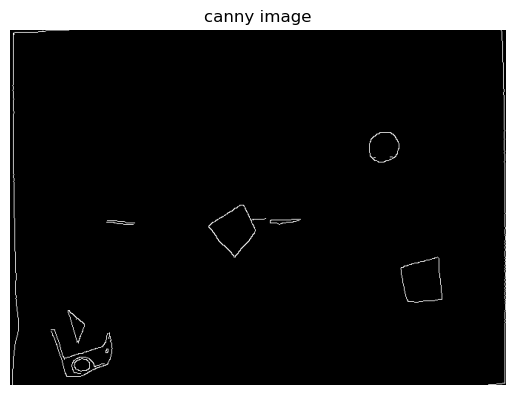

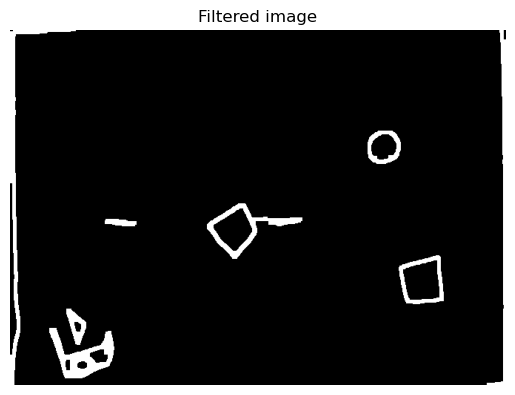

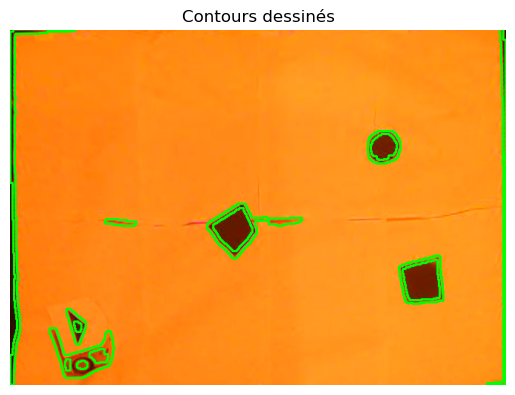

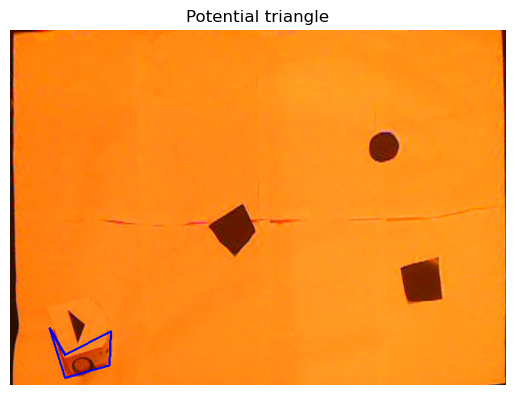

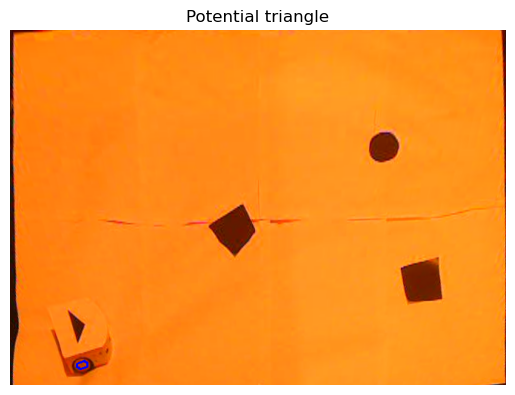

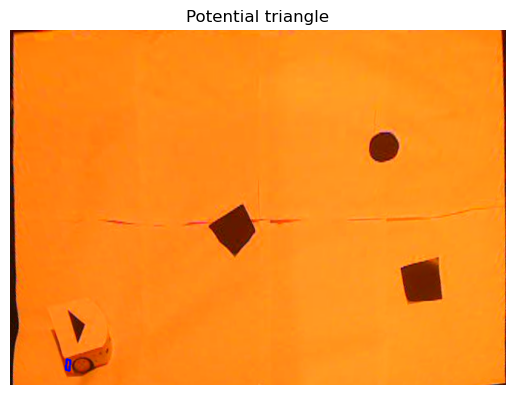

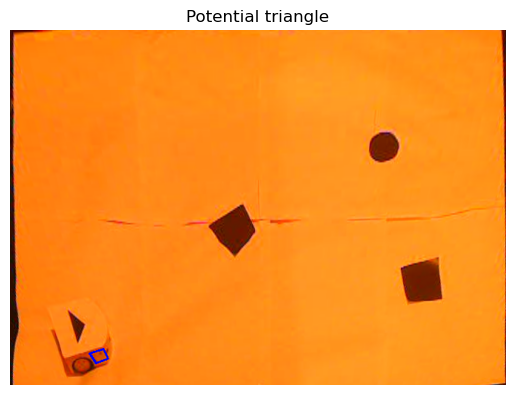

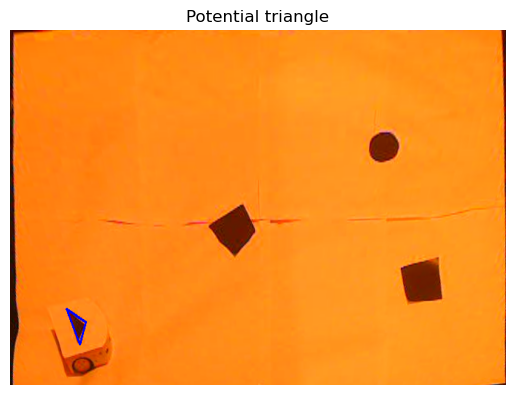

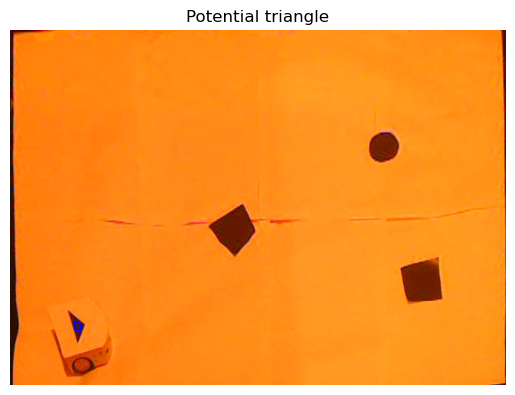

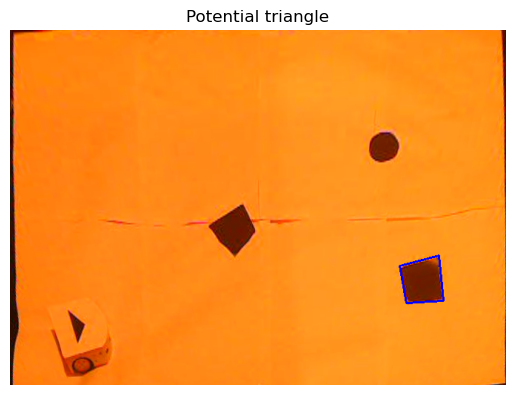

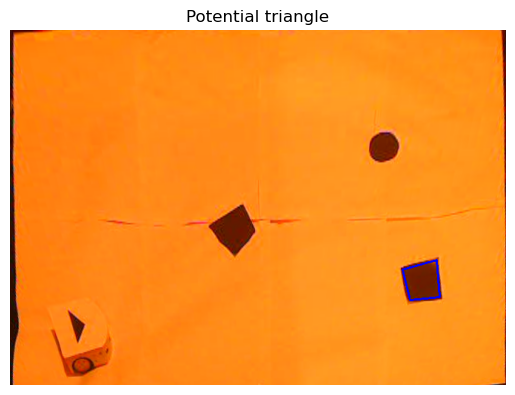

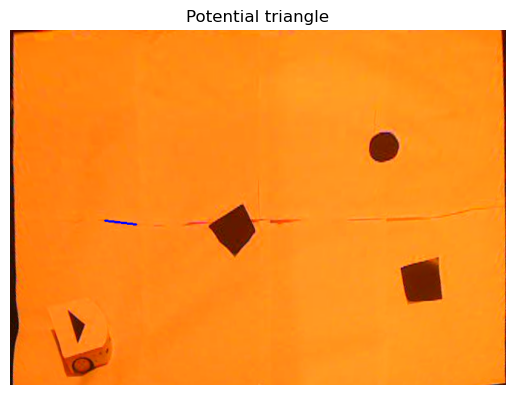

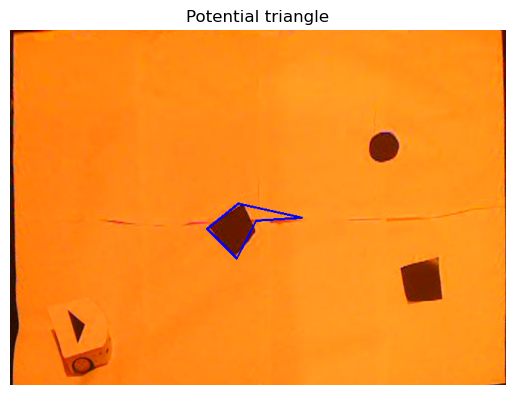

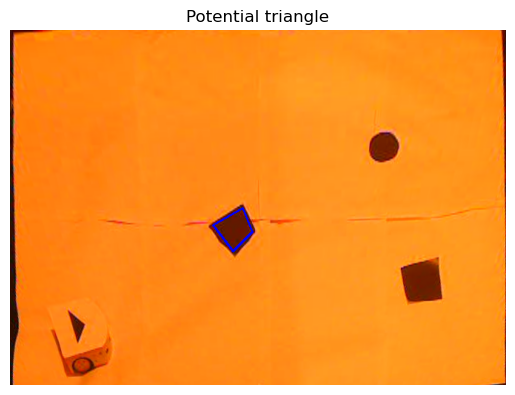

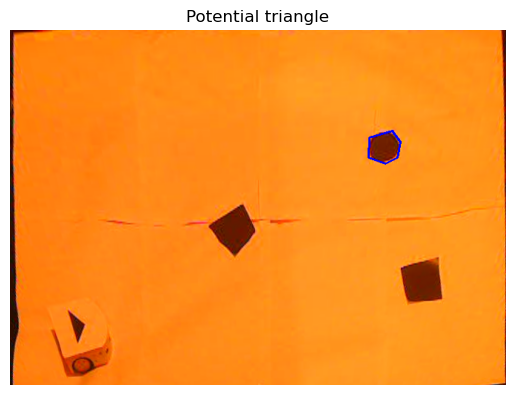

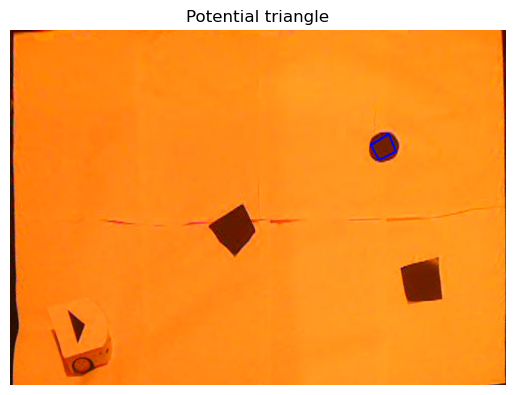

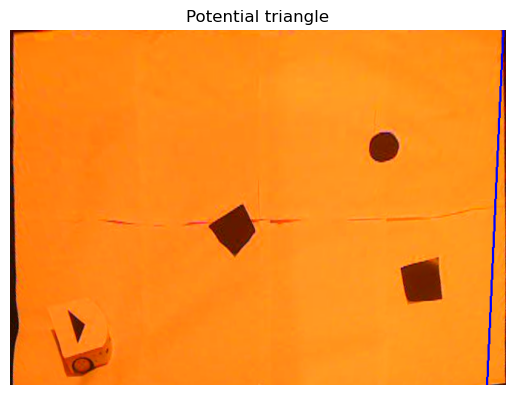

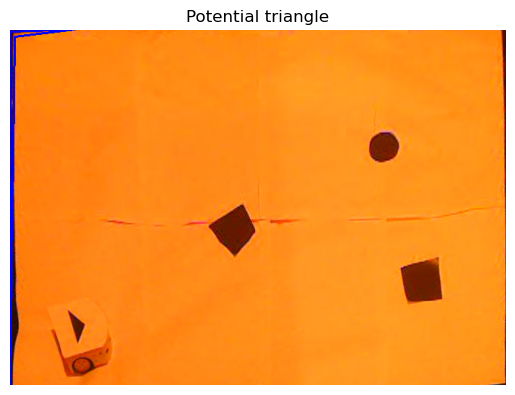

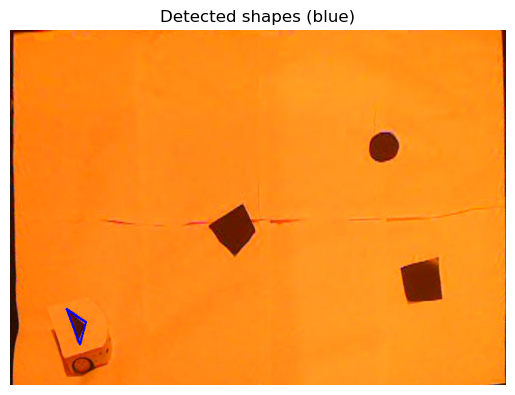

[[ 76 377]
 [ 94 425]
 [102 395]]
ROBOT FOUND


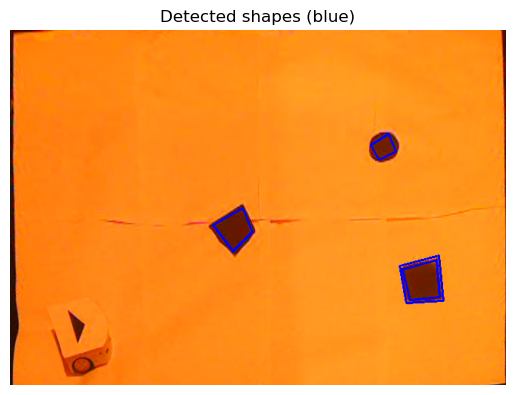

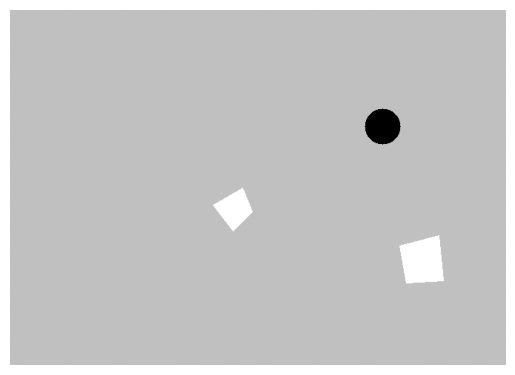

MAP ANALYZED : 
GOAL FOUND


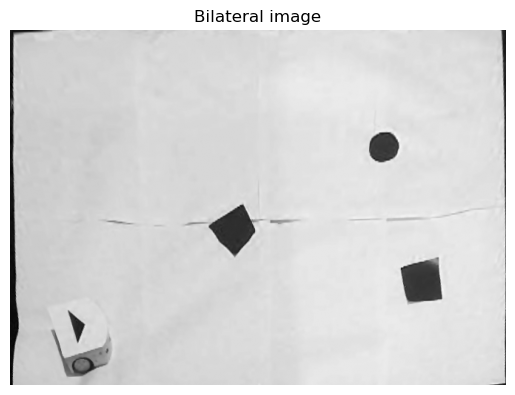

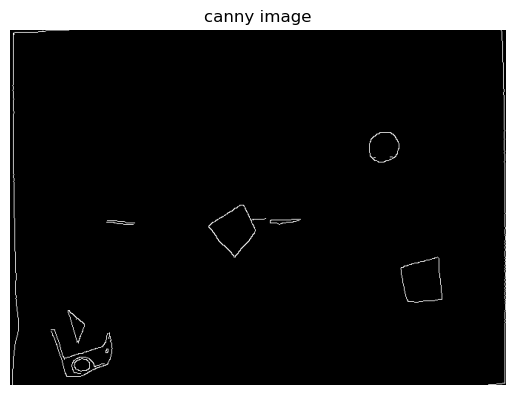

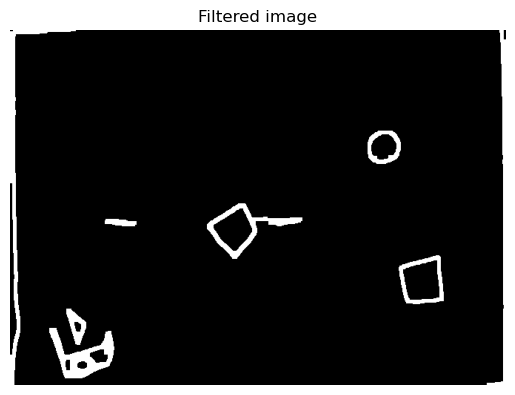

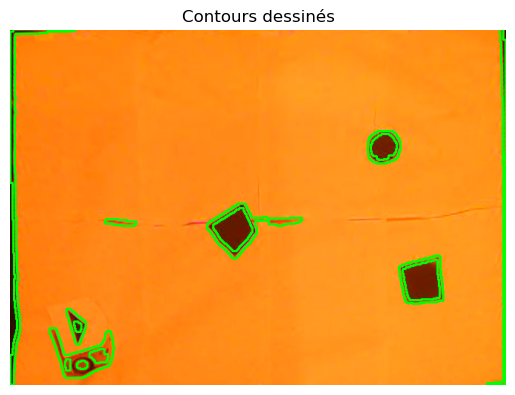

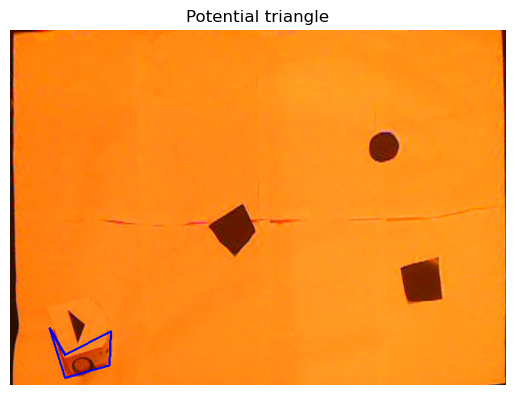

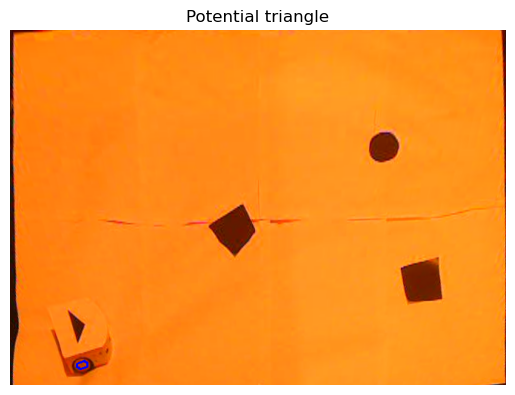

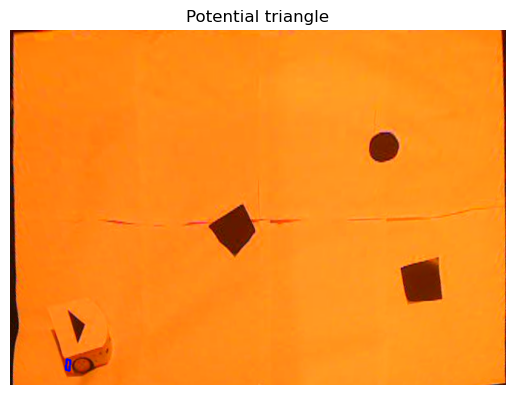

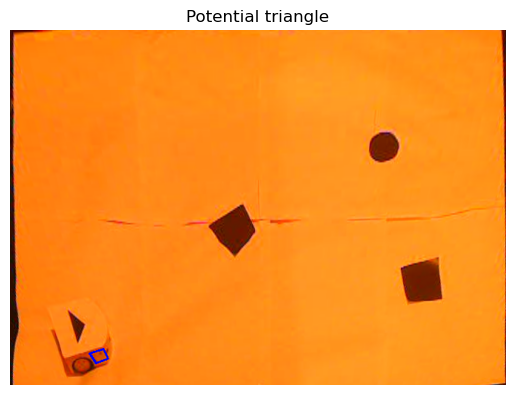

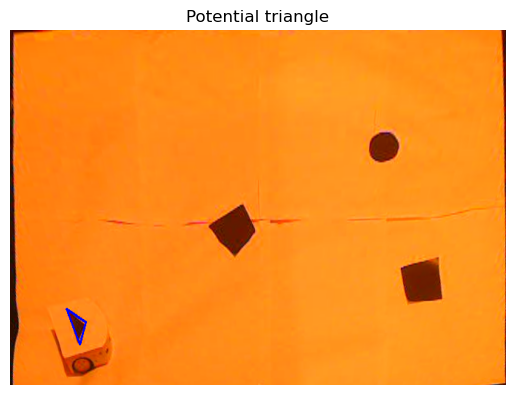

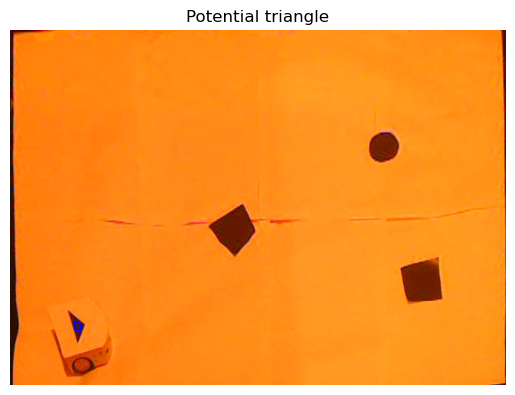

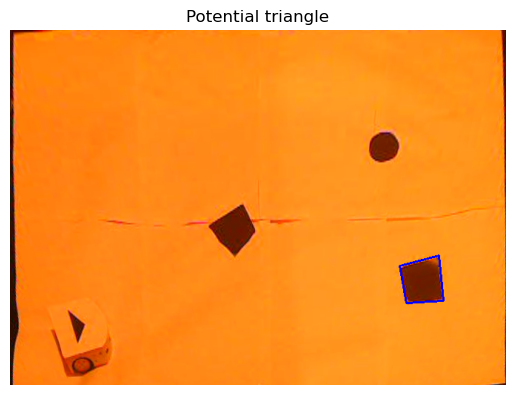

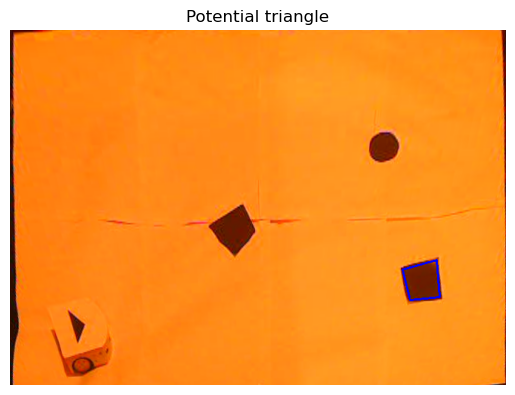

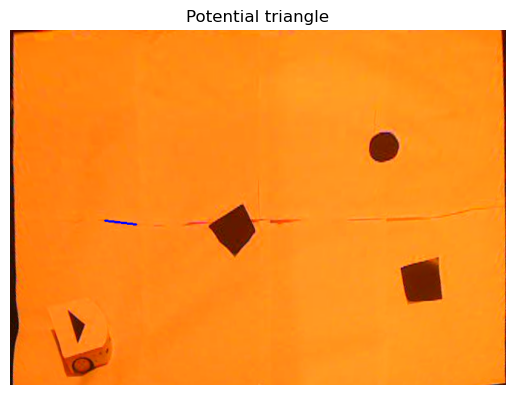

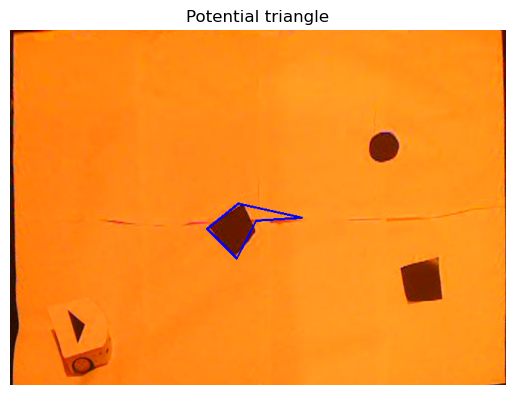

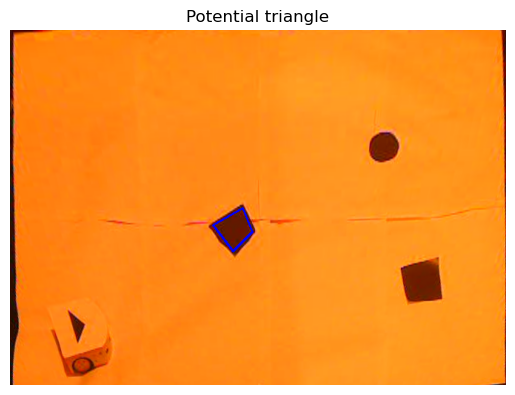

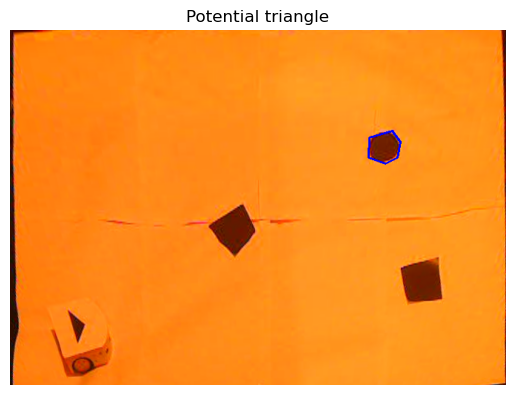

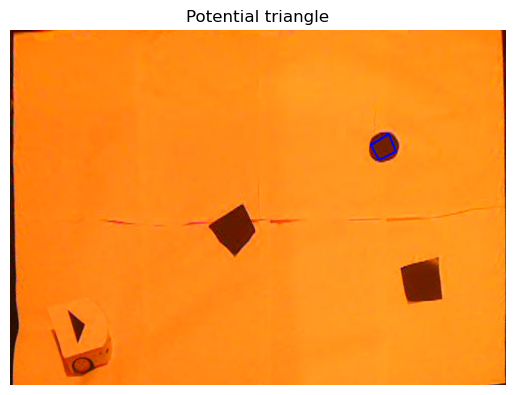

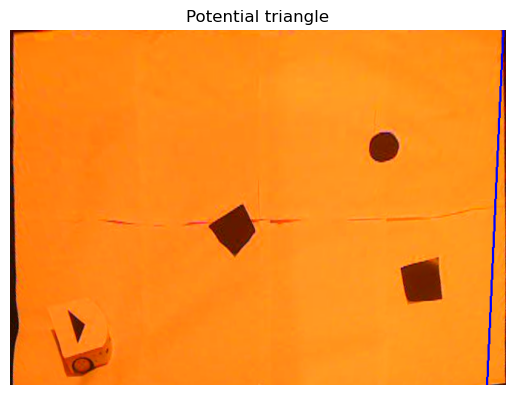

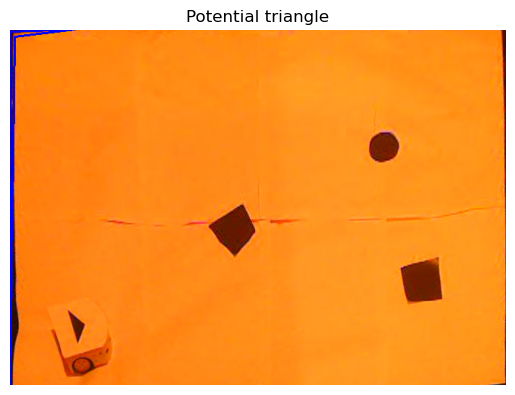

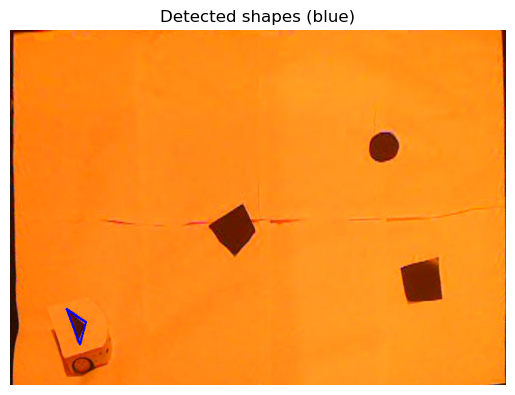

[[ 76 377]
 [ 94 425]
 [102 395]]
ROBOT FOUND
((np.int32(102), np.int32(395)), np.float64(-0.35877067027057225), True)


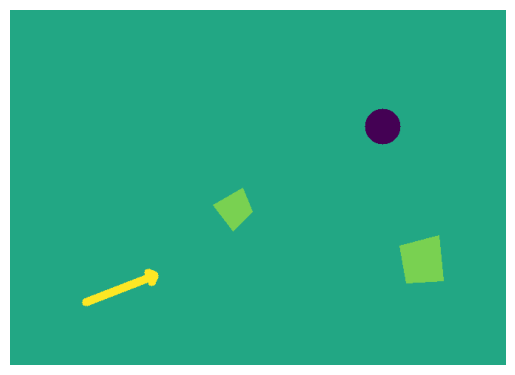

In [17]:
#ON WHAT PICTURE DO I WANT TO WORK

#EXTRACT PICTURE FROM THE CAMERA
#img = get_picture_optimized(cap)

#LOAD A PICTURE FROM THE REPOSITORY
img = cv2.imread("02.png")
if img is None:
    raise ValueError("ERREUR : impossible de charger IMAGE_TEST1.jpg")

#COMPUTE THE TRANSFORMATION TO CORRECT PERSPECTIVE
matrix = matrix_perspective(img)

#CORRECT THE PERSPECTIVE
transformed_image = convert_perspective(img,matrix)

#PLOTTING
plt.figure()
plt.imshow(cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB))
plt.title("Perspective Corrected Image")
plt.axis('off')
plt.show()

#TO GET THE OCCUPANCY MAP + GOAL:
global_map = get_map(transformed_image)

#TO GET ROBOT POSITION
robot = get_robot(transformed_image)
print(robot)

#PLOTTING
global_map4plot = global_map.copy()
if robot[2] :
    length = 100
    end_x = int(robot[0][0] + length * np.cos(robot[1]))
    end_y = int(robot[0][1] + length * np.sin(robot[1]))
    end_point = (end_x, end_y)
    
    robot1 = [int(robot[0][0]),int(robot[0][1])]
    cv2.arrowedLine(global_map4plot, robot1, end_point, color=(2, 2, 2), thickness=10)


plt.imshow(global_map4plot)
plt.axis('off')
plt.show()